### Homework C - Transformer network for video frame prediction ###

Create dataset of microscopy images

In [171]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt

plt.set_cmap("gray")

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

<Figure size 640x480 with 0 Axes>

In [172]:
print(np.shape(dataset.resolve()))

(10, 64, 64, 1)


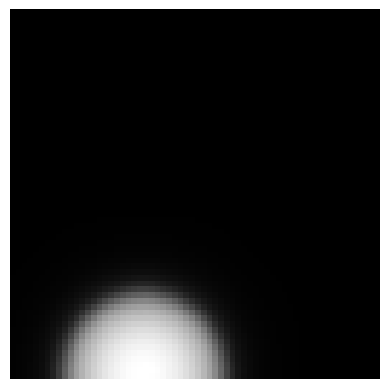

In [173]:
dataset.plot() # Plot first sequence

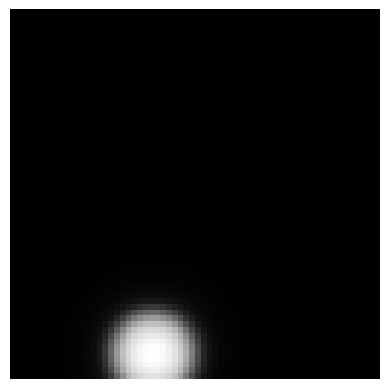

In [174]:
dataset.update().plot() # Plot updated sequence
video_sequence = dataset.update().resolve() # Get and store updated sequence

### Problem 1) Convolutional autoencoder ###

In [216]:
# Create dataset - training, validation and test
def create_dataset(train_len, val_len, test_len):
    train_data = []
    for i in range(train_len):
        train_data.extend(dataset.update().resolve())
    train_data = np.array(train_data)
    
    val_data = []
    for i in range(val_len):
        val_data.extend(dataset.update().resolve())
    val_data = np.array(val_data)
    
    test_data = []
    for i in range(test_len):
        test_data.extend(dataset.update().resolve())
    test_data = np.array(test_data)
    
    return train_data, val_data, test_data

create_autoenc_dataset = False

if create_autoenc_dataset:
    train_data, val_data, test_data = create_dataset(train_len=2000, val_len=200, test_len=200)
    # save data
    np.save('train_data.npy', train_data)
    np.save('val_data.npy', val_data)
    np.save('test_data.npy', test_data)

In [217]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
scaler = MinMaxScaler()

# load data
train_data = np.load('train_data.npy')
val_data = np.load('val_data.npy')
test_data = np.load('test_data.npy')
# normalize data

train_data = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(train_data.shape)
val_data = scaler.transform(val_data.reshape(-1, 1)).reshape(val_data.shape)
test_data = scaler.transform(test_data.reshape(-1, 1)).reshape(test_data.shape)

In [218]:
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(20000, 64, 64, 1)
(2000, 64, 64, 1)
(2000, 64, 64, 1)


In [219]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64, 1)), 
            # Encoder
            layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2), # 64x64 -> 32x32
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), 
            layers.Flatten(), # 2D -> 1D
            layers.Dense(latent_dim, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(8*8*16, activation='relu'),
            layers.Reshape((8, 8, 16)), # 1D -> 2D
            
            # Decoder
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

latent_dim = 256 # dimensions of the vector representation fed to decoder from encoder
autoencoder = Autoencoder(latent_dim=latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.encoder.summary()
autoencoder.decoder.summary()       

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 16)          4624      
                                                                 
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dense_100 (Dense)           (None, 256)               262400    
                                                                 
Total params: 286,128
Trainable params: 286,128
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
__________________________

Train the autoencoder 

In [220]:
autoencoder.fit(x=train_data, y=train_data, epochs=30, shuffle=True, validation_data=(val_data, val_data))

Epoch 1/30
625/625 [==============================] - 52s 82ms/step - loss: 0.0016 - val_loss: 1.5813e-04
Epoch 2/30
625/625 [==============================] - 49s 79ms/step - loss: 1.1915e-04 - val_loss: 6.4298e-05
Epoch 3/30
625/625 [==============================] - 50s 80ms/step - loss: 5.1313e-05 - val_loss: 4.6891e-05
Epoch 4/30
625/625 [==============================] - 51s 82ms/step - loss: 5.6021e-05 - val_loss: 3.9937e-05
Epoch 5/30
625/625 [==============================] - 52s 83ms/step - loss: 5.6350e-05 - val_loss: 7.0155e-05
Epoch 6/30
625/625 [==============================] - 51s 82ms/step - loss: 3.6215e-05 - val_loss: 2.6051e-05
Epoch 7/30
625/625 [==============================] - 52s 83ms/step - loss: 2.8135e-05 - val_loss: 2.3631e-05
Epoch 8/30
625/625 [==============================] - 51s 82ms/step - loss: 5.0432e-05 - val_loss: 2.2226e-05
Epoch 9/30
625/625 [==============================] - 50s 81ms/step - loss: 2.1136e-05 - val_loss: 3.3670e-05
Epoch 10/30
62

Visualize results

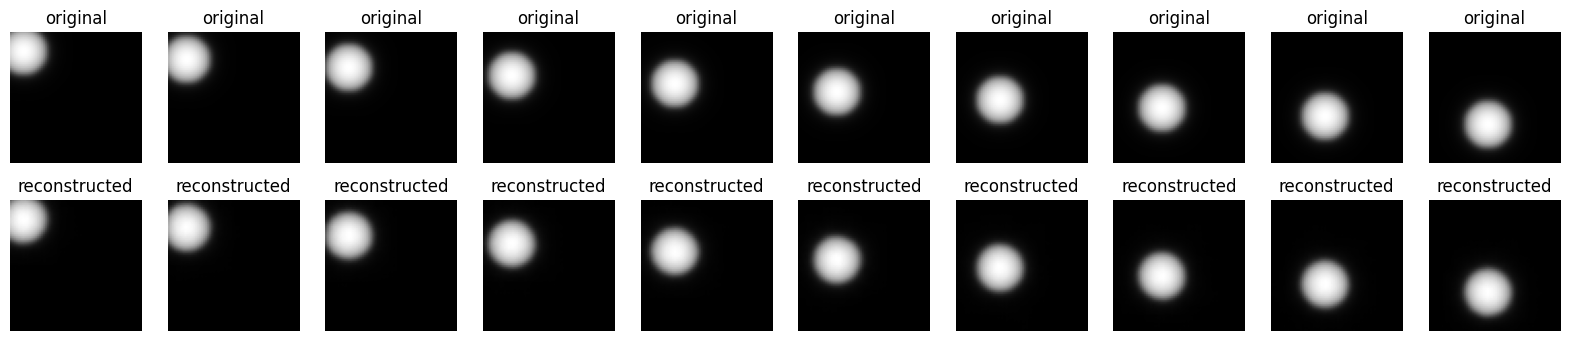

In [221]:
import matplotlib.pyplot as plt
%matplotlib inline

encoded_images = autoencoder.encoder(test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images): # plot original and reconstructed images for first sequence    
    ax = plt.subplot(2, n_images, i + 1) # original images
    plt.title("original")
    plt.imshow(tf.squeeze(test_data[i]))
    plt.axis("off")
    
    bx = plt.subplot(2, n_images, i+n_images+1) # reconstructed images
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_images[i]))
    plt.axis("off")
plt.show()

### Problem 2) Transformer encoder ###

Create dataset

In [222]:
create_dataset = False
train_len = int(1e4)
val_len = int(1e3)

if create_dataset:
  train_pictures = []
  for i in range(train_len):
    train_pictures.extend(dataset.update().resolve())
  train_pictures = np.array(train_pictures).reshape(train_len, 10, 64, 64, 1) 
  np.save('train_pictures.npy', train_pictures)

  val_pictures = []
  for i in range(val_len):
    val_pictures.extend(dataset.update().resolve())
  val_pictures = np.array(val_pictures).reshape(val_len, 10, 64, 64, 1)  
  np.save('val_pictures.npy', val_pictures)

In [223]:
# Read in dataset
if not create_dataset:
    train_pictures = np.load('train_pictures_10k.npy')
    val_pictures = np.load('val_pictures_1k.npy')

In [224]:
# Normalize dataset
print(np.shape(train_pictures))
print(np.shape(val_pictures))

train_pictures = scaler.transform(train_pictures.reshape(-1, 1)).reshape(train_pictures.shape)
val_pictures = scaler.transform(val_pictures.reshape(-1, 1)).reshape(val_pictures.shape)

(10000, 10, 64, 64, 1)
(1000, 10, 64, 64, 1)


In [257]:
# The aim is to train frame prediction, so we remove tenth frame from each sequence
train_frames, train_targets = tf.split(train_pictures, [9, 1], axis=1)
val_frames, val_targets = tf.split(val_pictures, [9, 1], axis=1)

# encode the frames using the encoder part of the autoencoder
train_sequences = np.array([autoencoder.encoder(train_frames[i]) for i in range(train_len)])
val_sequences = np.array([autoencoder.encoder(val_frames[i]) for i in range(val_len)])

# Verify data shapes
print("Train frames shape:", train_frames.shape)
print("Train targets shape:", train_targets.shape)
print("Train sequences shape:", train_sequences.shape)
print()
print("Val frames shape:", val_frames.shape)
print("Val targets shape:", val_targets.shape)
print("Val sequences shape:", val_sequences.shape)

Train frames shape: (10000, 9, 64, 64, 1)
Train targets shape: (10000, 1, 64, 64, 1)
Train sequences shape: (10000, 9, 256)

Val frames shape: (1000, 9, 64, 64, 1)
Val targets shape: (1000, 1, 64, 64, 1)
Val sequences shape: (1000, 9, 256)


Construct time embedding layer

In [258]:
Layer = tf.keras.layers.Layer

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        
    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                                shape = (int(self.seq_len),),
                                                initializer = 'uniform',
                                                trainable = True)
        
        self.bias_linear = self.add_weight(name='bias_linear',
                                            shape = (int(self.seq_len),),
                                            initializer = 'uniform',
                                            trainable = True)
        
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape = (int(self.seq_len),),
                                                initializer = 'uniform',
                                                trainable = True)
        
        self.bias_periodic = self.add_weight(name='bias_periodic',
                                                shape = (int(self.seq_len),),
                                                initializer = 'uniform',
                                                trainable = True)
        
    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Average over the latent space dimension
        
        time_linear = self.weights_linear * x + self.bias_linear # Linear part of the model
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension of length 1 for concatenation
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic) # Periodic part of the model
        time_periodic = tf.expand_dims(time_periodic, axis=-1) 
        
        return tf.concat([time_linear, time_periodic], axis=-1) # Concatenate linear and periodic parts
        # Final shape of output is (seq_len, 2)
            

Construct Transformer encoder with multi-head attention

In [259]:
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Conv1D, Dense

class TransformerEncoder(Layer):
    def __init__(self, head_dim, n_heads, ff_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.d_k = self.d_v = head_dim
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.attn = MultiHeadAttention(num_heads=self.n_heads, key_dim=self.d_k,
                                        value_dim=self.d_v, dropout=self.dropout_rate)
        
        self.dropout = Dropout(self.dropout_rate)
        self.norm = LayerNormalization(epsilon=1e-6)
              
        self.ff_dense = Dense(self.ff_dim, activation='relu')
        
    def call(self, inputs):
        attn = self.attn(inputs, inputs, inputs)
        attn = self.dropout(attn)
        attn = self.norm(inputs + attn)
        
        ff = self.ff_dense(attn)
        ff = self.dropout(ff)
        ff = self.ff_dense(ff)
        ff = self.dropout(ff)
        ff = self.ff_dense(ff)
        
        out = self.norm(inputs + ff)
        
        return out

In [268]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D, Dense

# Do not train the decoder
autoencoder.decoder.trainable = False

def create_transformers_model(latent_dim, seq_len, head_dim, n_heads, ff_dim, dropout_rate):

    time_embedding = Time2Vector(seq_len)
    dropout = Dropout(dropout_rate)
    attn_layer1 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    attn_layer2 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    attn_layer3 = TransformerEncoder(head_dim, n_heads, ff_dim, dropout_rate)
    
    dense_layer1 = Dense(latent_dim, activation='relu')
    dense_layer2 = Dense(latent_dim, activation='relu')
    dense_layer3 = Dense(latent_dim, activation='relu')
    
    input_seq = Input(shape=(seq_len, latent_dim)) # each frame is represented as a latent_dim-dimensional vector
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x]) # Join time_embedding output (linear and periodic) with input_seq
    x = attn_layer1(x)
    x = attn_layer2(x)
    x = attn_layer3(x)
    x = GlobalAveragePooling1D()(x)
    
    x = dense_layer1(x)
    x = dropout(x)
    x = dense_layer2(x)
    x = dropout(x)
    x = dense_layer3(x)
    
    out = autoencoder.decoder(x)
    
    model = Model(inputs=input_seq, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
    
    return model

seq_len = 9 
head_dim = latent_dim + 2
ff_dim = latent_dim + 2
n_heads = 4
dropout_rate = 0.2


model = create_transformers_model(latent_dim, seq_len, head_dim, n_heads, ff_dim, dropout_rate)
model.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_74 (InputLayer)          [(None, 9, 256)]     0           []                               
                                                                                                  
 time2_vector_65 (Time2Vector)  (None, 9, 2)         36          ['input_74[0][0]']               
                                                                                                  
 concatenate_65 (Concatenate)   (None, 9, 258)       0           ['input_74[0][0]',               
                                                                  'time2_vector_65[0][0]']        
                                                                                                  
 transformer_encoder_80 (Transf  (None, 9, 258)      1135716     ['concatenate_65[0][0]']  

Train the model

In [269]:
seq_len = 9 
head_dim = latent_dim + 2
ff_dim = latent_dim + 2
n_heads = 4
dropout_rate = 0.2

model_transformers = create_transformers_model(latent_dim, seq_len, head_dim, n_heads, ff_dim, dropout_rate)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_transformers.fit(train_sequences, train_targets, epochs=30, validation_data=(val_sequences, val_targets),
          shuffle = True, callbacks = callback)

Epoch 1/30
313/313 [==============================] - 72s 222ms/step - loss: 0.0135 - mae: 0.0502 - mse: 0.0135 - val_loss: 0.0134 - val_mae: 0.0547 - val_mse: 0.0134
Epoch 2/30
313/313 [==============================] - 67s 214ms/step - loss: 0.0129 - mae: 0.0514 - mse: 0.0129 - val_loss: 0.0130 - val_mae: 0.0519 - val_mse: 0.0130
Epoch 3/30
313/313 [==============================] - 67s 215ms/step - loss: 0.0120 - mae: 0.0499 - mse: 0.0120 - val_loss: 0.0112 - val_mae: 0.0474 - val_mse: 0.0112
Epoch 4/30
313/313 [==============================] - 67s 215ms/step - loss: 0.0108 - mae: 0.0470 - mse: 0.0108 - val_loss: 0.0109 - val_mae: 0.0490 - val_mse: 0.0109
Epoch 5/30
313/313 [==============================] - 68s 218ms/step - loss: 0.0107 - mae: 0.0465 - mse: 0.0107 - val_loss: 0.0108 - val_mae: 0.0490 - val_mse: 0.0108
Epoch 6/30
313/313 [==============================] - 68s 217ms/step - loss: 0.0105 - mae: 0.0462 - mse: 0.0105 - val_loss: 0.0108 - val_mae: 0.0501 - val_mse: 0.010

Test prediction ability

1/1 [==============================] - 0s 19ms/step


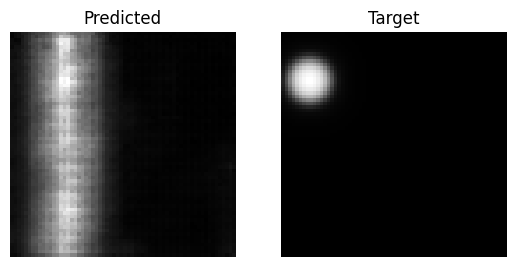

1/1 [==============================] - 0s 24ms/step


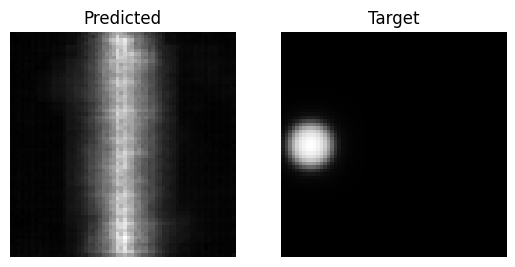

1/1 [==============================] - 0s 17ms/step


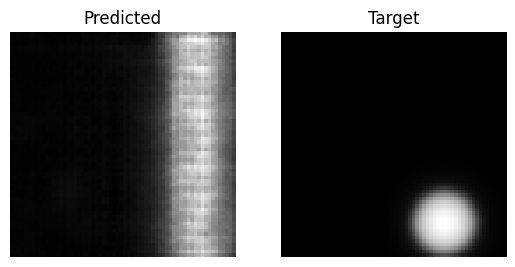

In [277]:
for i in range(3):
    # Generate test sequence
    test_sequence = []
    for j in range(1):
        test_sequence.append(np.array(dataset.update().resolve()))
    test_sequence = np.array(test_sequence)
    test_sequence = scaler.transform(test_sequence.reshape(-1, 1)).reshape(test_sequence.shape)
    
    test_frames, test_targets = tf.split(test_sequence, [9, 1], axis=1)

    test_frames_enc = np.array([autoencoder.encoder(frame) for frame in test_frames])
    # Feed the 9 test frames to the model
    test_pred = model_transformers.predict(test_frames_enc)

    pred_frame = test_pred[0]
    target_frame = tf.squeeze(test_targets[0], axis=0)

    # compare the predicted frame to the target
    plt.subplot(1, 2, 1)
    plt.imshow(scaler.inverse_transform(pred_frame.reshape(-1, 1)).reshape(pred_frame.shape))
    plt.title("Predicted")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(scaler.inverse_transform(target_frame.numpy().reshape(-1, 1)).reshape(target_frame.shape))
    plt.title("Target")
    plt.axis("off")
    plt.show()

Create a RNN to compare against

In [272]:
from tensorflow.keras.layers import LSTM

# Do not train the decoder
autoencoder.decoder.trainable = False

def create_LSTM_model(latent_dim, seq_len, dropout_rate):

    time_embedding = Time2Vector(seq_len)
    dropout = Dropout(dropout_rate)
    LSTM_layer1 = LSTM(latent_dim, return_sequences=True, activation='relu') # return the whole sequence for the first LSTM layer
    LSTM_layer2 = LSTM(latent_dim, return_sequences=True, activation='relu') # return the whole sequence for the first LSTM layer
    LSTM_layer3 = LSTM(latent_dim, return_sequences=False, activation='relu') # return only the last output for last LSTM layer
    
    dense_layer1 = Dense(latent_dim, activation='relu')
    dense_layer2 = Dense(latent_dim, activation='relu')
    dense_layer3 = Dense(latent_dim, activation='relu')
    
    input_seq = Input(shape=(seq_len, latent_dim))
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = LSTM_layer1(x)
    x = LSTM_layer2(x)
    x = LSTM_layer3(x)
    
    x = dropout(x)
    x = dense_layer1(x)
    x = dropout(x)
    x = dense_layer2(x)
    x = dropout(x)
    x = dense_layer3(x)
    
    out = autoencoder.decoder(x)
    
    model = Model(inputs=input_seq, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
    
    return model

seq_len = 9 
dropout_rate = 0.5

model = create_LSTM_model(latent_dim, seq_len, dropout_rate)
model.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 9, 256)]     0           []                               
                                                                                                  
 time2_vector_68 (Time2Vector)  (None, 9, 2)         36          ['input_77[0][0]']               
                                                                                                  
 concatenate_68 (Concatenate)   (None, 9, 258)       0           ['input_77[0][0]',               
                                                                  'time2_vector_68[0][0]']        
                                                                                                  
 lstm_48 (LSTM)                 (None, 9, 256)       527360      ['concatenate_68[0][0]']  

In [273]:
seq_len = 9 
dropout_rate = 0.5

model_LSTM = create_LSTM_model(latent_dim, seq_len, dropout_rate)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_LSTM.fit(train_sequences, train_targets, epochs=30, validation_data=(val_sequences, val_targets),
          shuffle = True, callbacks = callback)

Epoch 1/30
313/313 [==============================] - 82s 239ms/step - loss: 0.0138 - mae: 0.0487 - mse: 0.0138 - val_loss: 0.0137 - val_mae: 0.0529 - val_mse: 0.0137
Epoch 2/30
313/313 [==============================] - 74s 236ms/step - loss: 0.0126 - mae: 0.0508 - mse: 0.0126 - val_loss: 0.0115 - val_mae: 0.0493 - val_mse: 0.0115
Epoch 3/30
313/313 [==============================] - 74s 237ms/step - loss: 0.0112 - mae: 0.0480 - mse: 0.0112 - val_loss: 0.0109 - val_mae: 0.0456 - val_mse: 0.0109
Epoch 4/30
313/313 [==============================] - 74s 237ms/step - loss: 0.0108 - mae: 0.0469 - mse: 0.0108 - val_loss: 0.0107 - val_mae: 0.0462 - val_mse: 0.0107
Epoch 5/30
313/313 [==============================] - 74s 236ms/step - loss: 0.0106 - mae: 0.0465 - mse: 0.0106 - val_loss: 0.0106 - val_mae: 0.0467 - val_mse: 0.0106
Epoch 6/30
313/313 [==============================] - 74s 236ms/step - loss: 0.0106 - mae: 0.0461 - mse: 0.0106 - val_loss: 0.0106 - val_mae: 0.0466 - val_mse: 0.010

1/1 [==============================] - 0s 210ms/step
(64, 64, 1)


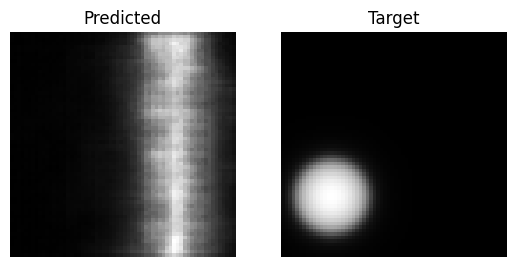

1/1 [==============================] - 0s 13ms/step
(64, 64, 1)


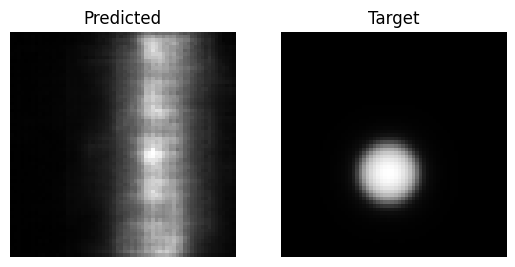

1/1 [==============================] - 0s 15ms/step
(64, 64, 1)


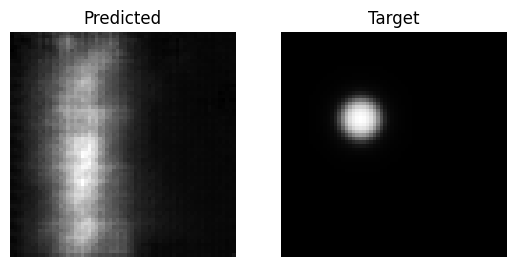

In [274]:
for i in range(3):
    # Generate test sequence
    test_sequence = []
    for j in range(1):
        test_sequence.append(np.array(dataset.update().resolve()))
    test_sequence = np.array(test_sequence)
    test_sequence = scaler.transform(test_sequence.reshape(-1, 1)).reshape(test_sequence.shape)
    
    test_frames, test_targets = tf.split(test_sequence, [9, 1], axis=1)

    test_frames_enc = np.array([autoencoder.encoder(frame) for frame in test_frames])
    # Feed the 9 test frames to the model
    test_pred = model_LSTM.predict(test_frames_enc)

    pred_frame = test_pred[0]
    print(pred_frame.shape)
    target_frame = tf.squeeze(test_targets[0], axis=0)

    # compare the predicted frame to the target
    plt.subplot(1, 2, 1)
    plt.imshow(scaler.inverse_transform(pred_frame.reshape(-1, 1)).reshape(pred_frame.shape))
    plt.title("Predicted")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(scaler.inverse_transform(target_frame.numpy().reshape(-1, 1)).reshape(target_frame.shape))
    plt.title("Target")
    plt.axis("off")
    plt.show()